# De-noising Feedforward Autoencoder
##### MNIST reconstruction

Import dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Util functions

function to plot the images after during testing phase

In [2]:
def plot_images(images, title, no_i_x, no_i_y=3):
    fig = plt.figure(figsize=(10, 15))
    fig.canvas.set_window_title(title)
    images = np.array(images).reshape(-1, 28, 28)
    for i in range(no_i_x):
        for j in range(no_i_y):
            ax = fig.add_subplot(no_i_x, no_i_y, no_i_x * j + (i + 1))
            ax.matshow(images[no_i_x * j + i], cmap="gray")
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

            if j == 0 and i == 0:
                ax.set_title("Real")
            elif j == 0 and i == 1:
                ax.set_title("Distorted")
            elif j == 0 and i == 2:
                ax.set_title("Reconstructed")

function to add noise to input data

In [3]:
def add_noise(data, mean=0, stddev=0.2):
    try:
        noise = np.random.normal(mean, stddev, data.shape)
    except ValueError:
        noise = np.zeros_like(data)

    noisy_data = data + noise
    clipped_noisy_data = np.clip(noisy_data, 0.0, 1.0)

    return clipped_noisy_data

load the mmist dataset from tensorflow.examples

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
features_train, features_test, features_valid = \
    mnist.train.images, mnist.test.images, mnist.validation.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural Network Model
2 Encoder layers + 2 Decoder layers (all dense neural layers)

<br>Hyper-parameters

In [5]:
n_input_layer = features_train.shape[1]
n_enc_hidden_1 = 400
n_enc_hidden_2 = 100  # 7.84 times compression
n_dec_hidden_1 = 100
n_dec_hidden_2 = 400
n_output_layer = features_train.shape[1]

learning_rate = 0.001

n_epoch = 10
batch_size = 100

test_disp = 10  # no of images in plot

input/output placeholders

In [6]:
X = tf.placeholder(tf.float32, [None, n_input_layer])
Y = tf.placeholder(tf.float32, [None, n_output_layer])

Weights and biases

In [7]:
enc_layer_1 = {
    'weights': tf.Variable(tf.random_normal([n_input_layer, n_enc_hidden_1], stddev=0.1)),
    'biases': tf.Variable(tf.random_normal([n_enc_hidden_1], stddev=0.1))
}
enc_layer_2 = {
    'weights': tf.Variable(tf.random_normal([n_enc_hidden_1, n_enc_hidden_2], stddev=0.1)),
    'biases': tf.Variable(tf.random_normal([n_enc_hidden_2], stddev=0.1))
}
dec_layer_1 = {
    'weights': tf.Variable(tf.random_normal([n_dec_hidden_1, n_dec_hidden_2], stddev=0.1)),
    'biases': tf.Variable(tf.random_normal([n_dec_hidden_2], stddev=0.1))
}
dec_layer_2 = {
    'weights': tf.Variable(tf.random_normal([n_dec_hidden_2, n_output_layer], stddev=0.1)),
    'biases': tf.Variable(tf.random_normal([n_output_layer], stddev=0.1))
}

#### Model

Encoder

In [8]:
h_enc_1 = tf.add(tf.matmul(X, enc_layer_1['weights']), enc_layer_1['biases'])
enc_1 = tf.nn.sigmoid(h_enc_1)

h_enc_2 = tf.add(tf.matmul(enc_1, enc_layer_2['weights']), enc_layer_2['biases'])
enc_2 = tf.nn.tanh(h_enc_2)

Decoder

In [9]:
h_dec_1 = tf.add(tf.matmul(enc_2, dec_layer_1['weights']), dec_layer_1['biases'])
dec_1 = tf.nn.tanh(h_dec_1)

h_dec_2 = tf.add(tf.matmul(dec_1, dec_layer_2['weights']), dec_layer_2['biases'])
dec_2 = tf.nn.sigmoid(h_dec_2)

#### Error and Optimizer

In [10]:
# mean-squared error
cost = tf.losses.mean_squared_error(labels=Y, predictions=dec_2)

# adam-optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Training

Make Batches

In [11]:
n_batch = features_train.shape[0] // batch_size
batched_data = np.split(features_train, n_batch)

#### Start session

In [12]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print("*********** Train ***********")

    # Epoch-training
    for epoch in range(n_epoch):
        tr_err = []

        # Batch training
        for b_idx in range(n_batch):
            noisy_data = add_noise(batched_data[b_idx])
            e, _ = sess.run([cost, optimizer], feed_dict={X: noisy_data, Y: batched_data[b_idx]})

            tr_err.append(e)
            
        noisy_vaild_data = add_noise(features_valid)
        val_err = cost.eval({X: noisy_vaild_data, Y: features_valid})

        train_err = sum(tr_err) / len(tr_err)
        print("Epoch:", epoch, " Train-error:", train_err, " Validation-error:", val_err)
        
    print("\n*********** Test ***********")

    # Test the model on test data and try to reconstruct it
    noisy_test = add_noise(features_test)
    reconstructed_imgs, err = sess.run([dec_2, cost], feed_dict={X: noisy_test, Y: features_test})
    disp_imgs = []
    for i in range(test_disp):
        disp_imgs.append(features_test[i])
        disp_imgs.append(noisy_test[i])
        disp_imgs.append(reconstructed_imgs[i])

    # Plot original, noisy and reconstructed images
    print("Test Error: %.8f" % err)

*********** Train ***********
Epoch: 0  Train-error: 0.0326655690457  Validation-error: 0.0158167
Epoch: 1  Train-error: 0.012484143969  Validation-error: 0.0101491
Epoch: 2  Train-error: 0.00908060977659  Validation-error: 0.00839202
Epoch: 3  Train-error: 0.00768788457001  Validation-error: 0.00725421
Epoch: 4  Train-error: 0.0068269499713  Validation-error: 0.00660782
Epoch: 5  Train-error: 0.00626942924309  Validation-error: 0.00626707
Epoch: 6  Train-error: 0.00589494798248  Validation-error: 0.00591861
Epoch: 7  Train-error: 0.00564208484509  Validation-error: 0.00560433
Epoch: 8  Train-error: 0.00545295548879  Validation-error: 0.00550049
Epoch: 9  Train-error: 0.00528165180405  Validation-error: 0.00549375

*********** Test ***********
Test Error: 0.00539585


#### plot output

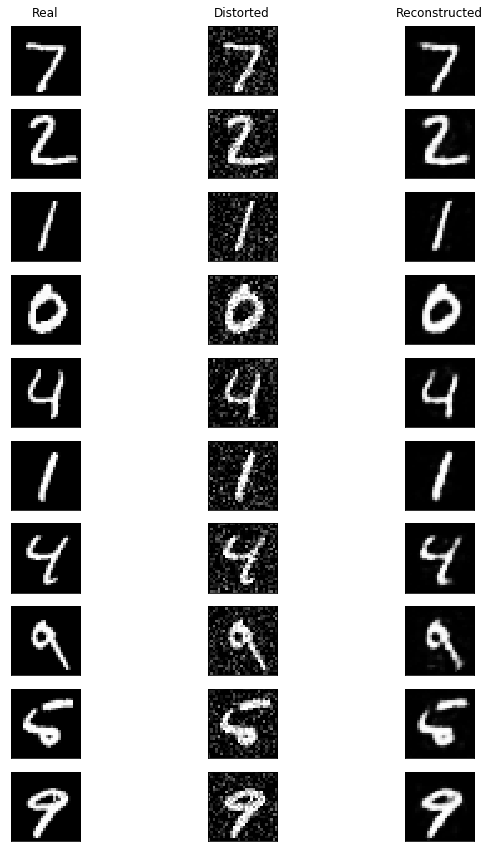

In [13]:
plot_images(disp_imgs, "De-noising Auto-encoder", test_disp)
plt.show()